# Experments Settings:
- mutation_rate = 0.01
- iterations = 100
- pool_size = 12
- Learning = Classification
- Target = Cover Type
- PCA  = False

In [1]:
import os
from time import time
import argparse
import numpy as np
from sklearn.svm import SVC

from sklearn.datasets import fetch_covtype, get_data_home
from sklearn.externals.joblib import Memory
from sklearn.metrics import zero_one_loss
from sklearn.externals.joblib import Memory
from sklearn.utils import check_array
from sklearn.datasets import fetch_mldata

import boto3
import pandas as pd
from sagemaker import get_execution_role
import seaborn as se
from genalgo import GenAlgo
from sklearn.linear_model import LinearRegression
import numpy as np
from numpy import array
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

In [2]:
memory = Memory(os.path.join(get_data_home(), 'covertype_benchmark_data'), mmap_mode='r')
@memory.cache
def load_data(dtype=np.float32, order='C', random_state=13):
    """Load the data, then cache and memmap the train/test split"""
    ######################################################################
    # Load dataset
    print("Loading dataset...")
    data = fetch_covtype(download_if_missing=True, shuffle=True,
                         random_state=random_state)
    X = check_array(data['data'], dtype=dtype, order=order)
    y = (data['target'] != 1).astype(np.int)
 
    # Create train-test split (as [Joachims, 2006])
    print("Creating train-test split...")
    n_train = 522911
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]
 
    # Standardize first 10 features (the numerical ones)
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    mean[10:] = 0.0
    std[10:] = 1.0
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    return X_train, X_test, y_train, y_test

In [3]:
X_train, X_test, y_train, y_test = load_data()

INFO:sklearn.datasets.covtype:Downloading https://ndownloader.figshare.com/files/5976039


________________________________________________________________________________
[Memory] Calling __main__--home-ec2-user-SageMaker-__ipython-input__.load_data...
load_data()
Loading dataset...
Creating train-test split...
_______________________________________________________load_data - 80.7s, 1.3min


## Run withouth Gen

In [4]:
logistic = SGDClassifier(loss='log', penalty='l2',max_iter=100000, tol=1e-5, random_state=0)
logistic.fit(X_train, y_train)

print("Trainning Accuracy {0} %".format(accuracy_score(y_train, logistic.predict(X_train))*100))


Trainning Accuracy 76.8692951573021 %


In [5]:
print("Testing Accuracy {0} %".format(accuracy_score(y_test, logistic.predict(X_test))*100))


Testing Accuracy 76.83860862979984 %


In [ ]:
clf = SVC(kernel='poly')
clf.fit(X_train, y_train)

In [ ]:
print("Trainning Accuracy with SVC {0} %".format(accuracy_score(y_train, clf.predict(X_train))*100))


## GenAlgo

Iteration 10 Complete [Time Taken For Last Iteration: 174.11 Seconds]
Iteration 20 Complete [Time Taken For Last Iteration: 178.54 Seconds]
Iteration 40 Complete [Time Taken For Last Iteration: 152.58 Seconds]
Iteration 50 Complete [Time Taken For Last Iteration: 152.63 Seconds]
Iteration 60 Complete [Time Taken For Last Iteration: 154.75 Seconds]
Iteration 80 Complete [Time Taken For Last Iteration: 158.88 Seconds]
Iteration 90 Complete [Time Taken For Last Iteration: 160.28 Seconds]
Iteration 100 Complete [Time Taken For Last Iteration: 159.87 Seconds]


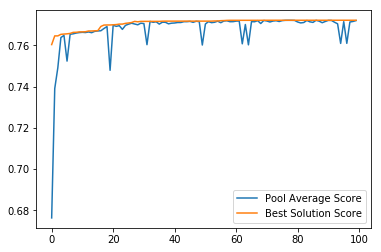

In [ ]:
#from genalgo import GenAlgo
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier

# Initialize the model
logistic = SGDClassifier(loss='log', penalty='l2',max_iter=100000, tol=1e-5, random_state=0)
# Initialize object of the Gen Algorithm
gfs = GenAlgo()


# Train the Algorithm
gfs.train(model=logistic, _type='classification', X=X_train, y=y_train, pca = False) # classification model

# get results output
binary_output_of_optimal_variables, indicies_of_optimal_variables = gfs.results()

# Visualize the performance
gfs.plot_progress()

In [7]:
def histfitness(gen):
    '''
    This method takes two paratmeters:
    - algo: the object of the genetic class.
    - generation: the order of the generation intended for analysis.
    
    The output is a histogram of the Fitness values of the Generation.
    '''
    try:
        value = int(gen)
    except ValueError:
        print('Type Error: generation must be an integer')
    rawlogs = gfs.iterations_results
    rawlogsDF = pd.DataFrame(rawlogs)
    rawlogsDF = rawlogsDF.transpose()
    rawlogsDF.columns = ['Fitness', 'Pool', 'Scores']
    Fitness = rawlogsDF.Fitness[gen]
    ax = se.distplot(Fitness, axlabel = 'Fitness', norm_hist = False, hist = True, kde = False)
    ax.set_title('Fitness Values Histogram')
    ax.set_ylabel('Counts')

    return ax

def histscores(gen):
    '''
    This method takes two paratmeters:
    - algo: the object of the genetic class.
    - generation: the order of the generation intended for analysis.
    
    The output is a histogram of the Scores values -F1 score as per class- of the Generation.
    '''
    try:
        value = int(gen)
    except ValueError:
        print('Type Error: generation must be an integer')
    rawlogs = gfs.iterations_results
    rawlogsDF = pd.DataFrame(rawlogs)
    rawlogsDF = rawlogsDF.transpose()
    rawlogsDF.columns = ['Fitness', 'Pool', 'Scores']
    Scores = rawlogsDF.Scores[gen]
    ax = se.distplot(Scores, axlabel = 'Scores', norm_hist = False, hist = True, kde = False)
    ax.set_title('Scores Values Histogram')
    ax.set_ylabel('Counts')

    return ax

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


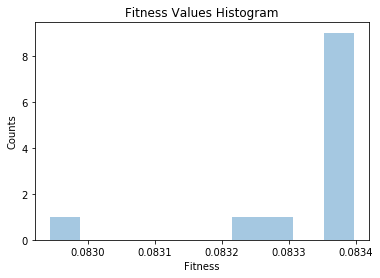

In [8]:
# plot fitness histogram of the 99th generation
histfitness(99)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


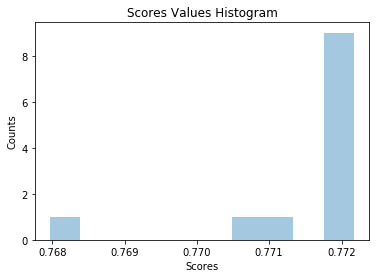

In [9]:
# plot scores histogram of the 99th generation
histscores(99)

In [10]:
def HighestClassificationScore(gen):
    rawlogs = gfs.iterations_results
    rawlogsDF = pd.DataFrame(rawlogs)
    rawlogsDF = rawlogsDF.transpose()
    rawlogsDF.columns = ['Fitness', 'Pool', 'Scores']
    Scores = rawlogsDF.Scores[gen]
    ax = se.distplot(Scores, axlabel = 'r2', norm_hist = False, hist = True, kde = False)
    Scores = rawlogsDF.Scores[gen]
    Scores = array(Scores)
    score = Scores.max()
    s = score*100
    
    
    return ax, print("Highet Score (accuracy) = %.2f" % s, "%")

Highet Score (accuracy) = 76.63 %


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f42908c88>, None)

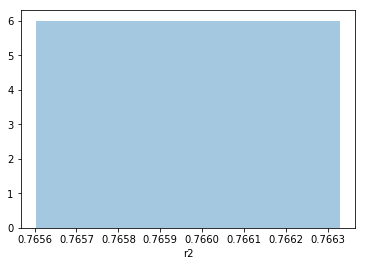

In [11]:
HighestClassificationScore(89)

In [31]:
# get the top most score among all the results along with the generation
def HighestClassificationScore():
    rawlogs = gfs.iterations_results
    rawlogsDF = pd.DataFrame(rawlogs)
    rawlogsDF = rawlogsDF.transpose()
    rawlogsDF.columns = ['Fitness', 'Pool', 'Scores']
    gen = 0
    allscores = list()
    while (gen !=100):
        Scores = rawlogsDF.Scores[gen]
        for i in Scores:
            allscores.append(i)
        gen = gen+1
    allscores = array(allscores)
    ax = se.distplot(allscores, axlabel = 'Accuracy', norm_hist = False, hist = True, kde = False)
    highest = allscores.max()
    s = highest*100
    return ax, print("Highest Score (accuracy) = %.2f" % s, "%")

Highest Score (accuracy) = 77.22 %


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(<matplotlib.axes._subplots.AxesSubplot at 0x7f4f3a9c6a58>, None)

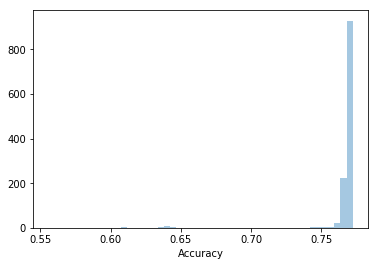

In [32]:
HighestClassificationScore()

In [28]:
allscores.max()

0.7721748878178273

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


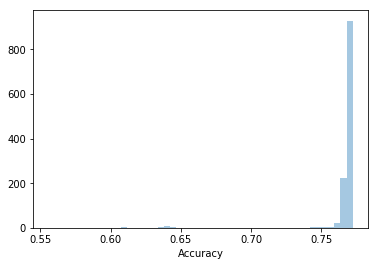

In [30]:
se.distplot(allscores, axlabel = 'Accuracy', norm_hist = False, hist = True, kde = False)

# PCA = True

Iteration 10 Complete [Time Taken For Last Iteration: 153.91 Seconds]
Iteration 20 Complete [Time Taken For Last Iteration: 159.89 Seconds]
Iteration 30 Complete [Time Taken For Last Iteration: 168.84 Seconds]
Iteration 40 Complete [Time Taken For Last Iteration: 165.06 Seconds]
Iteration 50 Complete [Time Taken For Last Iteration: 155.3 Seconds]
Iteration 60 Complete [Time Taken For Last Iteration: 157.15 Seconds]
Iteration 70 Complete [Time Taken For Last Iteration: 158.96 Seconds]
Iteration 80 Complete [Time Taken For Last Iteration: 152.99 Seconds]
Iteration 90 Complete [Time Taken For Last Iteration: 155.0 Seconds]
Iteration 100 Complete [Time Taken For Last Iteration: 152.66 Seconds]


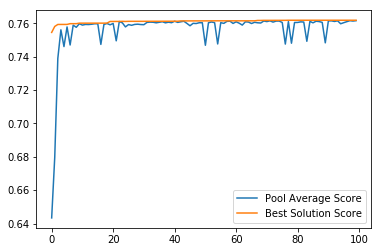

In [38]:
#from genalgo import GenAlgo
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier

# Initialize the model
logistic = SGDClassifier(loss='log', penalty='l2',max_iter=100000, tol=1e-5, random_state=0)
# Initialize object of the Gen Algorithm
gfs = GenAlgo()


# Train the Algorithm
gfs.train(model=logistic, _type='classification', X=X_train, y=y_train, pca = True) # classification model

# get results output
binary_output_of_optimal_variables, indicies_of_optimal_variables = gfs.results()

# Visualize the performance
gfs.plot_progress()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


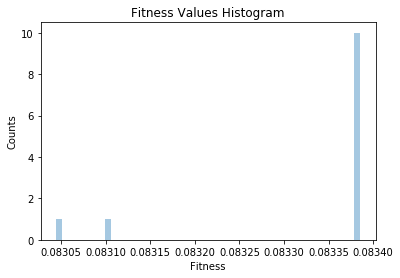

In [39]:
# plot fitness histogram of the 99th generation
histfitness(99)

Highet Score (accuracy) = 76.18 %


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb600b05cc0>, None)

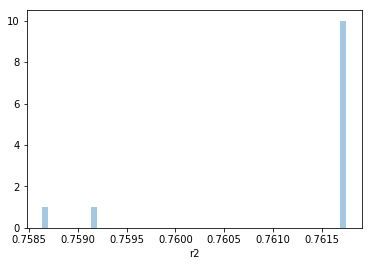

In [42]:
HighestClassificationScore(99)

In [43]:
def ClassificationScore(gen):
    rawlogs = gfs.iterations_results
    rawlogsDF = pd.DataFrame(rawlogs)
    rawlogsDF = rawlogsDF.transpose()
    rawlogsDF.columns = ['Fitness', 'Pool', 'Scores']
    Scores = rawlogsDF.Scores[gen]
    Scores = rawlogsDF.Scores[gen]
    Scores = array(Scores)
    score = Scores.max()
    s = score*100
    
    
    return print("Highet Score (accuracy) = %.2f" % s, "%")

In [44]:
ClassificationScore(9)
ClassificationScore(19)
ClassificationScore(29)
ClassificationScore(39)
ClassificationScore(49)
ClassificationScore(59)
ClassificationScore(69)
ClassificationScore(79)
ClassificationScore(89)
ClassificationScore(99)

Highet Score (accuracy) = 76.00 %
Highet Score (accuracy) = 76.11 %
Highet Score (accuracy) = 76.11 %
Highet Score (accuracy) = 76.14 %
Highet Score (accuracy) = 76.14 %
Highet Score (accuracy) = 76.14 %
Highet Score (accuracy) = 76.17 %
Highet Score (accuracy) = 76.17 %
Highet Score (accuracy) = 75.97 %
Highet Score (accuracy) = 76.18 %
